<a href="https://colab.research.google.com/github/ssudhakar165/colab/blob/main/faster_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import torch
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as pc

from torch.optim import adam
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [2]:

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/pascal.zip


Archive:  /content/drive/MyDrive/pascal.zip
  inflating: train.csv               
  inflating: val.csv                 
  inflating: train_images/2007_000027.jpg  
  inflating: train_images/2007_000032.jpg  
  inflating: train_images/2007_000033.jpg  
  inflating: train_images/2007_000039.jpg  
  inflating: train_images/2007_000042.jpg  
  inflating: train_images/2007_000061.jpg  
  inflating: train_images/2007_000063.jpg  
  inflating: train_images/2007_000068.jpg  
  inflating: train_images/2007_000121.jpg  
  inflating: train_images/2007_000123.jpg  
  inflating: train_images/2007_000129.jpg  
  inflating: train_images/2007_000170.jpg  
  inflating: train_images/2007_000175.jpg  
  inflating: train_images/2007_000187.jpg  
  inflating: train_images/2007_000241.jpg  
  inflating: train_images/2007_000243.jpg  
  inflating: train_images/2007_000250.jpg  
  inflating: train_images/2007_000256.jpg  
  inflating: train_images/2007_000272.jpg  
  inflating: train_images/2007_000323.jpg  


In [4]:
image= Image.open('')
image.sizetrain_images/2008_001510.jpg

(500, 377)

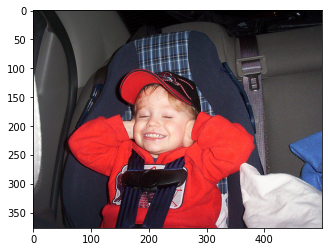

In [5]:
plt.imshow(image)

In [6]:
train= pd.read_csv('train.csv')


In [7]:
train.tail()

,filename,class,xmin,xmax,ymin,ymax
3987,2008_001501.jpg,person,337,356,183,236
3988,2008_001503.jpg,person,150,332,39,270
3989,2008_001503.jpg,chair,1,75,44,142
3990,2008_001504.jpg,person,84,270,17,500
3991,2008_001510.jpg,person,61,379,106,377


In [8]:
train["class"].value_counts()

person         1749
chair           298
car             275
bottle          162
pottedplant     156
dog             126
boat            124
bird            102
sheep            99
cat              98
tvmonitor        98
sofa             93
cow              92
motorbike        87
horse            86
bicycle          80
aeroplane        76
diningtable      71
train            63
bus              57
Name: class, dtype: int64

In [9]:
train.shape

(3992, 6)

In [10]:
train['class']= train['class'].replace({'person':1,'chair': 2, 'car':3, 'bottle':4, 'pottedplant':5,'dog':6,'boat':7, 'bird':8})
##train['class']= train['class'].replace({'person':1,'chair': 2})
train = train.loc[(train['xmax'] > train['xmin'] + 20) | (train['ymax'] > train['ymin'] + 20)]

In [11]:
train.head()

,filename,class,xmin,xmax,ymin,ymax
0,2007_000027.jpg,1,174,349,101,351
1,2007_000032.jpg,aeroplane,104,375,78,183
2,2007_000032.jpg,aeroplane,133,197,88,123
3,2007_000032.jpg,1,195,213,180,229
4,2007_000032.jpg,1,26,44,189,238


In [12]:
train.describe()

,xmin,xmax,ymin,ymax
count,3937.000000,3937.000000,3937.000000,3937.000000
mean,159.840742,316.383541,122.405893,297.517145
std,130.708355,128.194067,85.287408,101.827073
min,1.000000,8.000000,1.000000,16.000000
25%,43.000000,226.000000,55.000000,226.000000
50%,136.000000,324.000000,113.000000,304.000000
75%,254.000000,425.000000,178.000000,375.000000
max,489.000000,500.000000,432.000000,500.000000


In [13]:
train["class"].value_counts()

1              1732
2               298
3               262
4               160
5               155
6               126
7               119
8               102
cat              98
tvmonitor        97
sofa             93
cow              89
motorbike        87
horse            86
sheep            86
bicycle          80
aeroplane        76
diningtable      71
train            63
bus              57
Name: class, dtype: int64

In [14]:
train.rename(columns = {'class':'class1'}, inplace = True)

In [15]:
train= train.loc[ (train['class1']==0)|(train['class1']==1)|(train['class1']==2)|(train['class1']==3)|(train['class1']==4)|(train['class1']==5)|(train['class1']==6)|(train['class1']==7)]
##train= train.loc[ (train['class1']==1)|(train['class1']==2)|]

In [16]:
train.tail()

,filename,class1,xmin,xmax,ymin,ymax
3987,2008_001501.jpg,1,337,356,183,236
3988,2008_001503.jpg,1,150,332,39,270
3989,2008_001503.jpg,2,1,75,44,142
3990,2008_001504.jpg,1,84,270,17,500
3991,2008_001510.jpg,1,61,379,106,377


In [17]:
train['class1'].value_counts()

1    1732
2     298
3     262
4     160
5     155
6     126
7     119
Name: class1, dtype: int64

In [18]:
train.shape

(2852, 6)

In [19]:
from torchvision import transforms as TF

transform = TF.Compose([
   
    
    TF.ToTensor()
])

In [20]:
## convert list of list to tuple
def collate_fn(batch):
    return tuple(zip(*batch))

In [21]:
class pascalDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files
        self.imgs = train.filename.unique()

    def __getitem__(self, idx):
        # load images
        img_name = self.imgs[idx]
        img_path = os.path.join(self.root, img_name)
        img = Image.open(img_path)

        num_objs = train[train['filename'] == img_name].shape[0]
        boxes = []
        class1 = []
        for i in range(num_objs):
            xmin = train[train['filename'] == img_name]['xmin'].iloc[i]
            xmax = train[train['filename'] == img_name]['xmax'].iloc[i]
            ymin = train[train['filename'] == img_name]['ymin'].iloc[i]
            ymax = train[train['filename'] == img_name]['ymax'].iloc[i]
            target = train[train['filename'] == img_name]['class1'].iloc[i]
            boxes.append([xmin, ymin, xmax, ymax])
            class1.append(target)

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(  class1, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        if self.transforms is not None:
            img = self.transforms(img)
            boxes[:, 0] = boxes[:, 0]
            boxes[:, 2] = boxes[:, 2]
            boxes[:, 1] = boxes[:, 1]
            boxes[:, 3] = boxes[:, 3]

        return img, target

    def __len__(self):
        return len(self.imgs)

In [22]:
dataset = pascalDataset('/content/train_images', transforms=transform)

In [23]:
data_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=5, 
    shuffle=False, 
    collate_fn=collate_fn
)

In [24]:
for batch_x, batch_y in data_loader:
    break

In [25]:
batch_x[4].shape

torch.Size([3, 500, 334])

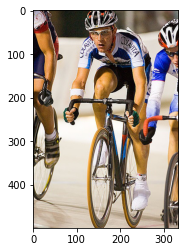

In [26]:
plt.imshow(np.transpose(batch_x[4], (1, 2, 0)))

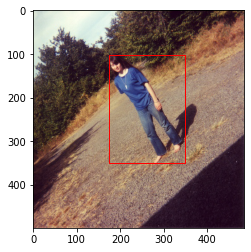

In [27]:
plt.axes()
from numpy import random
i= random.rand(len(train))
plt.imshow(np.transpose(batch_x[0], (1, 2, 0)))
for i in range(len(batch_y[0]['boxes'])):
    bbox = batch_y[0]['boxes'][i]
    x1, y1 = bbox[0], bbox[1]
    x2, y2 = bbox[2], bbox[3]

    if batch_y[0]['labels'][i] == 1:
        color = 'red'
    elif batch_y[0]['labels'][i] == 2:
        color = 'blue'
    elif batch_y[0]['labels'][i] == 3:
        color = 'green'
    elif batch_y[0]['labels'][i] == 4:
        color = 'yellow'
    elif batch_y[0]['labels'][i] == 5:
        color = 'orange'
    elif batch_y[0]['labels'][i] == 6:
        color = 'black'
    elif batch_y[0]['labels'][i] == 7:
        color = 'blue'  
    rectangle = pc.Rectangle((x1,y1), x2-x1, y2-y1, fc='none',color=color)
    plt.gca().add_patch(rectangle)
plt.show()


In [28]:
model = fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [29]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [30]:
num_classes = 8
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [31]:
in_features

1024

In [32]:
batch_x[1].shape

torch.Size([3, 281, 500])

In [33]:
model.eval()
output = model(batch_x[1].view(1, 3, 281,500))

In [34]:
output

[{'boxes': tensor([[1.8499e+02, 8.8752e+01, 2.0620e+02, 1.0888e+02],
          [1.7040e+02, 8.8371e+01, 1.9215e+02, 1.0906e+02],
          [1.6808e+02, 9.0208e+01, 2.1694e+02, 1.0796e+02],
          [3.7125e+02, 1.5118e+02, 3.9303e+02, 1.7441e+02],
          [0.0000e+00, 1.3114e+02, 7.6943e+01, 1.4634e+02],
          [1.7455e+02, 8.9309e+01, 1.9507e+02, 1.0670e+02],
          [1.1925e+02, 1.0514e+02, 1.5819e+02, 1.1680e+02],
          [1.8172e+02, 9.3312e+01, 2.2762e+02, 1.0951e+02],
          [1.7850e+02, 8.1089e+01, 3.8441e+02, 1.2513e+02],
          [1.4258e+02, 8.3950e+01, 2.4738e+02, 1.0442e+02],
          [1.6132e+02, 9.0061e+01, 1.8811e+02, 1.1299e+02],
          [1.8431e+02, 9.1430e+01, 1.9266e+02, 1.0497e+02],
          [1.9322e+02, 8.6473e+01, 2.1801e+02, 1.0842e+02],
          [0.0000e+00, 1.2518e+02, 7.4976e+00, 1.4255e+02],
          [8.8122e+01, 2.1830e+02, 1.1796e+02, 2.2968e+02],
          [2.4837e+02, 1.1229e+02, 3.4454e+02, 1.3777e+02],
          [9.1476e+00, 1.8511e+

In [35]:
model = model.to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [51]:
model.train()

# train model
for epoch in range(10):

    # initialize variables
    epoch_classif_loss = epoch_regress_loss = cnt = 0

    # loop through the data
    for batch_x, batch_y in data_loader:
        # get batch images and targets and transfer them to GPU
        batch_x = list(image.to("cuda") for image in batch_x)
        batch_y = [{k: v.to("cuda") for k, v in t.items()} for t in batch_y]

        # clear gradients
        optimizer.zero_grad()

        # pass images to model and get loss
        loss_dict = model(batch_x, batch_y)
        losses = sum(loss for loss in loss_dict.values())

        # do a backward pass
        losses.backward()

        # update gradients
        optimizer.step()

        # sum loss and get count
        epoch_classif_loss += loss_dict['loss_classifier'].item()
        epoch_regress_loss += loss_dict['loss_box_reg'].item()
        cnt += 1

    # take average loss for all batches
    epoch_classif_loss /= cnt
    epoch_regress_loss /= cnt
    
    # print loss
    print("Training loss for epoch {} is {} for classification and {} for regression "
        .format(epoch + 1, epoch_classif_loss, epoch_regress_loss)
    )

Training loss for epoch 1 is 0.056327568188957546 for classification and 0.1049030253663659 for regression 
Training loss for epoch 2 is 0.051371035992127397 for classification and 0.09836238715797663 for regression 
Training loss for epoch 3 is 0.04417372080699905 for classification and 0.09385707311980103 for regression 
Training loss for epoch 4 is 0.041246720427728215 for classification and 0.08720321364538824 for regression 
Training loss for epoch 5 is 0.03532189203264273 for classification and 0.08089055684597596 for regression 
Training loss for epoch 6 is 0.03378570377826691 for classification and 0.08224132753422726 for regression 
Training loss for epoch 7 is 0.032113885697301316 for classification and 0.0765228164827694 for regression 
Training loss for epoch 8 is 0.030144073712922957 for classification and 0.07214219201680111 for regression 
Training loss for epoch 9 is 0.02877923210920847 for classification and 0.07221262987865054 for regression 
Training loss for epoch 1

In [52]:
image = Image.open('val_images/2008_002470.jpg')
image = transform(image)

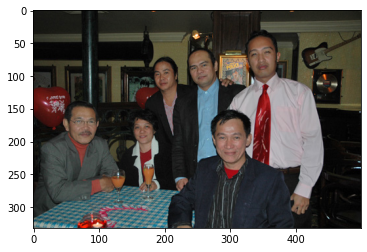

In [53]:
plt.imshow(np.transpose(image, (1, 2, 0)))

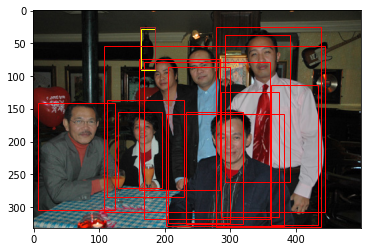

people tensor(13)
chair tensor(0)
car tensor(0)
bottle tensor(1)
pottedplant tensor(0)
dog tensor(0)
boat tensor(1)
bird tensor(0)


In [54]:
model.eval()
output = model(image.unsqueeze(dim=0).cuda())
output = [{k: v.to("cpu") for k, v in t.items()} for t in output]

# plot bounding box
plt.axes()
plt.imshow(np.transpose(image, (1, 2, 0)))
for i in range(len(output[0]['boxes'])):
    bbox = output[0]['boxes'][i]
    x1, y1 = bbox[0], bbox[1]
    x2, y2 = bbox[2], bbox[3]

    if output[0]['labels'][i] == 1:
        color = 'red'
    elif output[0]['labels'][i] == 2:
        color = 'blue'
    elif output[0]['labels'][i] == 3:
        color = 'green'
    elif output[0]['labels'][i] == 4:
        color = 'yellow'
    elif output[0]['labels'][i] == 5:
        color = 'orange'
    elif output[0]['labels'][i] == 6:
        color = 'black'
    elif output[0]['labels'][i] == 7:
        color = 'brown'
    
    rectangle = pc.Rectangle((x1,y1), x2-x1, y2-y1, fc='none',color=color)
    plt.gca().add_patch(rectangle)
plt.show()
print('people', (output[0]['labels'] == 1).sum())
print('chair', (output[0]['labels'] == 2).sum())
print('car', (output[0]['labels'] == 3).sum())
print('bottle', (output[0]['labels'] == 4).sum())
print('pottedplant', (output[0]['labels'] == 5).sum())
print('dog', (output[0]['labels'] == 6).sum())
print('boat', (output[0]['labels'] == 7).sum())
print('bird', (output[0]['labels'] == 8).sum())

If you increase the epochs , the error comes down. Pl check the same image at 10 epochs to 5 epochs in below.


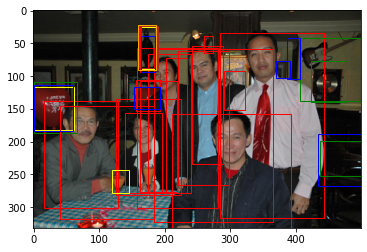

people tensor(17)
chair tensor(6)
car tensor(5)
bottle tensor(3)
pottedplant tensor(1)
dog tensor(0)
boat tensor(1)
bird tensor(0)


In [50]:
model.eval()
output = model(image.unsqueeze(dim=0).cuda())
output = [{k: v.to("cpu") for k, v in t.items()} for t in output]

# plot bounding box
plt.axes()
plt.imshow(np.transpose(image, (1, 2, 0)))
for i in range(len(output[0]['boxes'])):
    bbox = output[0]['boxes'][i]
    x1, y1 = bbox[0], bbox[1]
    x2, y2 = bbox[2], bbox[3]

    if output[0]['labels'][i] == 1:
        color = 'red'
    elif output[0]['labels'][i] == 2:
        color = 'blue'
    elif output[0]['labels'][i] == 3:
        color = 'green'
    elif output[0]['labels'][i] == 4:
        color = 'yellow'
    elif output[0]['labels'][i] == 5:
        color = 'orange'
    elif output[0]['labels'][i] == 6:
        color = 'black'
    elif output[0]['labels'][i] == 7:
        color = 'brown'
    
    rectangle = pc.Rectangle((x1,y1), x2-x1, y2-y1, fc='none',color=color)
    plt.gca().add_patch(rectangle)
plt.show()
print('people', (output[0]['labels'] == 1).sum())
print('chair', (output[0]['labels'] == 2).sum())
print('car', (output[0]['labels'] == 3).sum())
print('bottle', (output[0]['labels'] == 4).sum())
print('pottedplant', (output[0]['labels'] == 5).sum())
print('dog', (output[0]['labels'] == 6).sum())
print('boat', (output[0]['labels'] == 7).sum())
print('bird', (output[0]['labels'] == 8).sum())

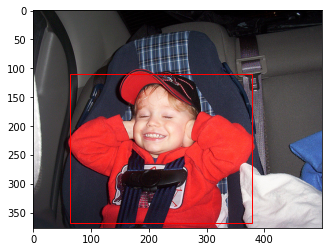

people tensor(1)
chair tensor(0)
car tensor(0)
bottle tensor(0)
pottedplant tensor(0)
dog tensor(0)
boat tensor(0)
bird tensor(0)


In [55]:
image = Image.open('train_images/2008_001510.jpg')
image = transform(image)
model.eval()
output = model(image.unsqueeze(dim=0).cuda())
output = [{k: v.to("cpu") for k, v in t.items()} for t in output]

# plot bounding box
plt.axes()
plt.imshow(np.transpose(image, (1, 2, 0)))
for i in range(len(output[0]['boxes'])):
    bbox = output[0]['boxes'][i]
    x1, y1 = bbox[0], bbox[1]
    x2, y2 = bbox[2], bbox[3]

    if output[0]['labels'][i] == 1:
        color = 'red'
    elif output[0]['labels'][i] == 2:
        color = 'blue'
    elif output[0]['labels'][i] == 3:
        color = 'green'
    elif output[0]['labels'][i] == 4:
        color = 'yellow'
    elif output[0]['labels'][i] == 5:
        color = 'orange'
    elif output[0]['labels'][i] == 6:
        color = 'black'
    elif output[0]['labels'][i] == 7:
        color = 'brown'
    
    rectangle = pc.Rectangle((x1,y1), x2-x1, y2-y1, fc='none',color=color)
    plt.gca().add_patch(rectangle)
plt.show()
print('people', (output[0]['labels'] == 1).sum())
print('chair', (output[0]['labels'] == 2).sum())
print('car', (output[0]['labels'] == 3).sum())
print('bottle', (output[0]['labels'] == 4).sum())
print('pottedplant', (output[0]['labels'] == 5).sum())
print('dog', (output[0]['labels'] == 6).sum())
print('boat', (output[0]['labels'] == 7).sum())
print('bird', (output[0]['labels'] == 8).sum())